<h2 align=center>Tumor Diagnosis: EDA</h2>

### About the Dataset:

The [Breast Cancer Diagnostic data](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) is available on the UCI Machine Learning Repository. 

Data Set Information:

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. A few of the images can be found at [Web Link]

Separating plane described above was obtained using Multisurface Method-Tree (MSM-T) [K. P. Bennett, "Decision Tree Construction Via Linear Programming." Proceedings of the 4th Midwest Artificial Intelligence and Cognitive Science Society, pp. 97-101, 1992], a classification method which uses linear programming to construct a decision tree. Relevant features were selected using an exhaustive search in the space of 1-4 features and 1-3 separating planes.

The actual linear program used to obtain the separating plane in the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server:
ftp ftp.cs.wisc.edu
cd math-prog/cpo-dataset/machine-learn/WDBC/


Attribute Information:

1) ID number
2) Diagnosis (M = malignant, B = benign)
3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)
b) texture (standard deviation of gray-scale values)
c) perimeter
d) area
e) smoothness (local variation in radius lengths)
f) compactness (perimeter^2 / area - 1.0)
g) concavity (severity of concave portions of the contour)
h) concave points (number of concave portions of the contour)
i) symmetry
j) fractal dimension ("coastline approximation" - 1)

###1. Loading Libraries and Data, Sanity Check

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns  
import matplotlib.pyplot as plt
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('data_cancer.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
data.drop('Unnamed: 32', axis=1).isna().sum().sum(), data.drop('Unnamed: 32', axis=1).duplicated().sum()

(0, 0)

<h2 align=center> Exploratory Data Analysis </h2>

---

### 2. Separate Target from Features

***

In [4]:
col = data.columns
col

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [5]:
y = data.diagnosis
drop_cols = ['id', 'Unnamed: 32', 'diagnosis']
x = data.drop(columns=drop_cols)
x.head(3)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [6]:
y.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

### 3. Plot Diagnosis Distributions

***

Number of benign: 357, number of malignant: 212


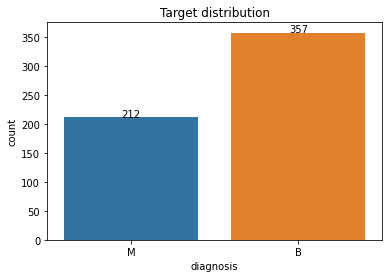

In [7]:
labels = y.value_counts().index
values = y.value_counts().values
ax = sns.countplot(y, label='Count')
plt.title('Target distribution')
B, M = y.value_counts()
print(f'Number of benign: {B}, number of malignant: {M}')

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1, values[i-1], ha='center')

In [8]:
x.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


<h2 align=center> Data Visualization </h2>

---

### 4. Visualizing Standardized Data with Seaborn
***

In [9]:
data = x
data_std = (data - data.mean())/data.std()
data = pd.concat([y, data_std.iloc[:, 0:10]], axis=1)
data = pd.melt(data, id_vars='diagnosis', var_name='features',
              value_name='value')
data.head()

,diagnosis,features,value
0,M,radius_mean,1.096100
1,M,radius_mean,1.828212
2,M,radius_mean,1.578499
3,M,radius_mean,-0.768233
4,M,radius_mean,1.748758


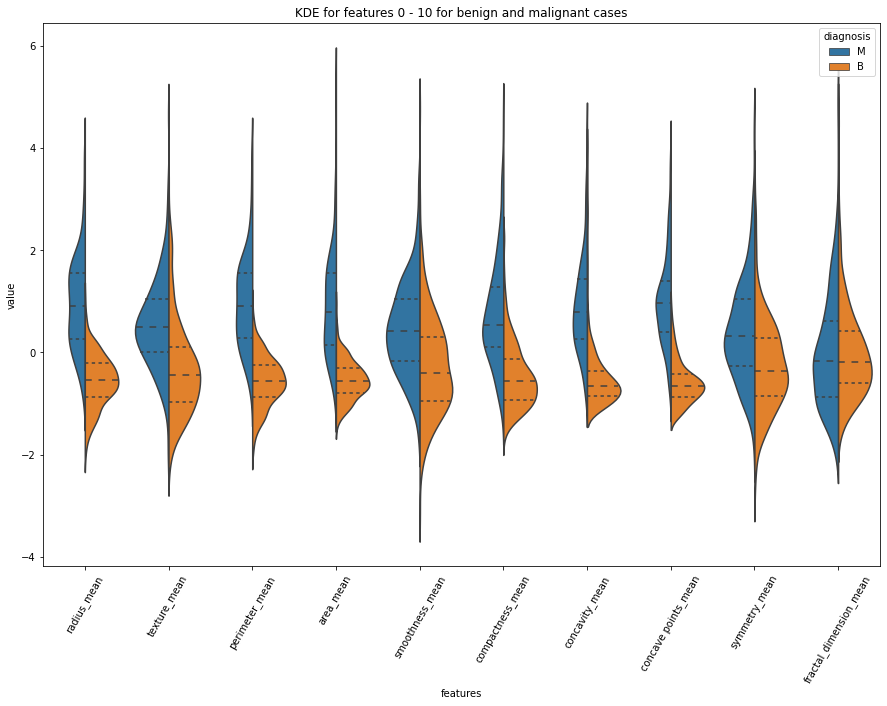

In [10]:
def violin_plot(data_std, start_feature=0):
    data = pd.concat([y, data_std.iloc[:, start_feature:start_feature+10]], axis=1)
    data = pd.melt(data, id_vars='diagnosis', var_name='features',
                value_name='value')
    plt.figure(figsize=(15, 10))
    sns.violinplot(x = 'features', y='value', hue='diagnosis', data=data, split=True, inner='quart')
    plt.title(f'KDE for features {start_feature} - {start_feature+10} for benign and malignant cases')
    plt.xticks(rotation=60);

violin_plot(data_std)

### 5. Violin Plots and Box Plots
***

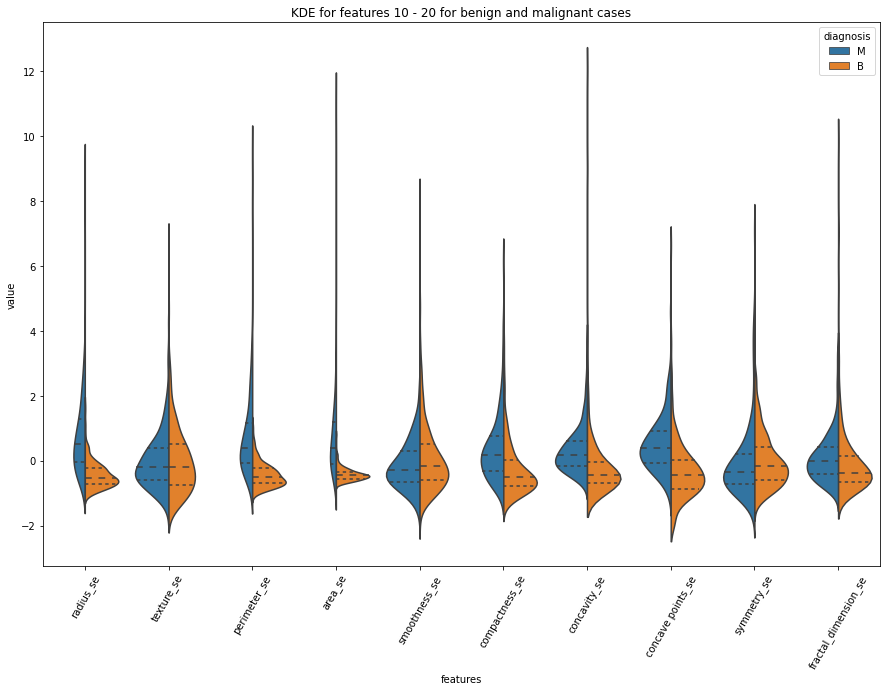

In [11]:
violin_plot(data_std, 10)

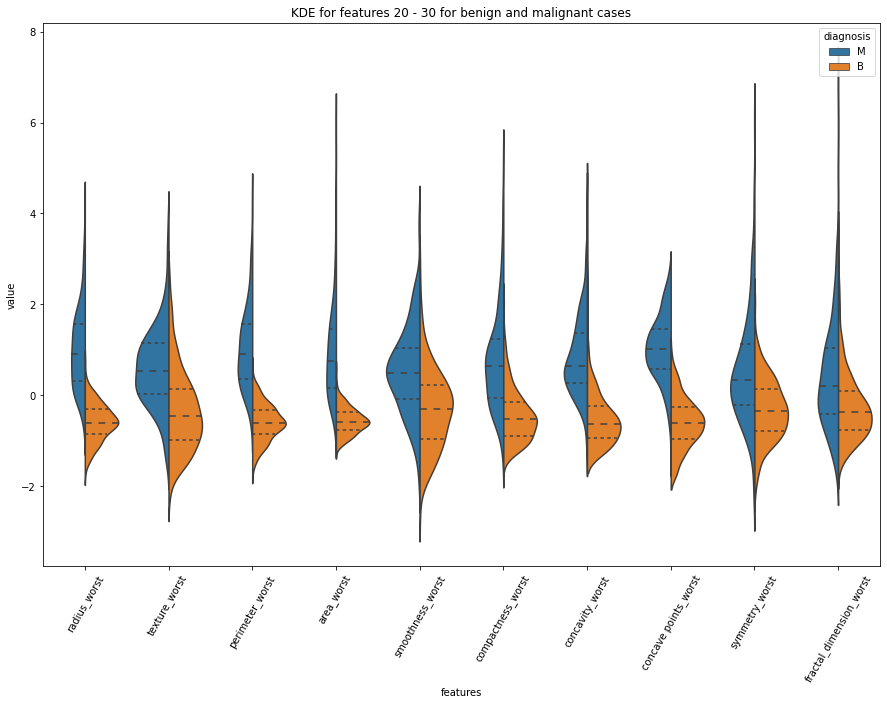

In [12]:
violin_plot(data_std, 20)

***
Conclusions from the violinplots:


- the less symmetric the violinplot for a specific feature the 'larger' is the difference in distribution of this feature values for target classes. Hence, the more important is this feature for future classification


- candidate features to drop: 'fractal dimension mean', 'texture se', 'symmetry se', 'smoothness se - these features look least sensitive to the target

***

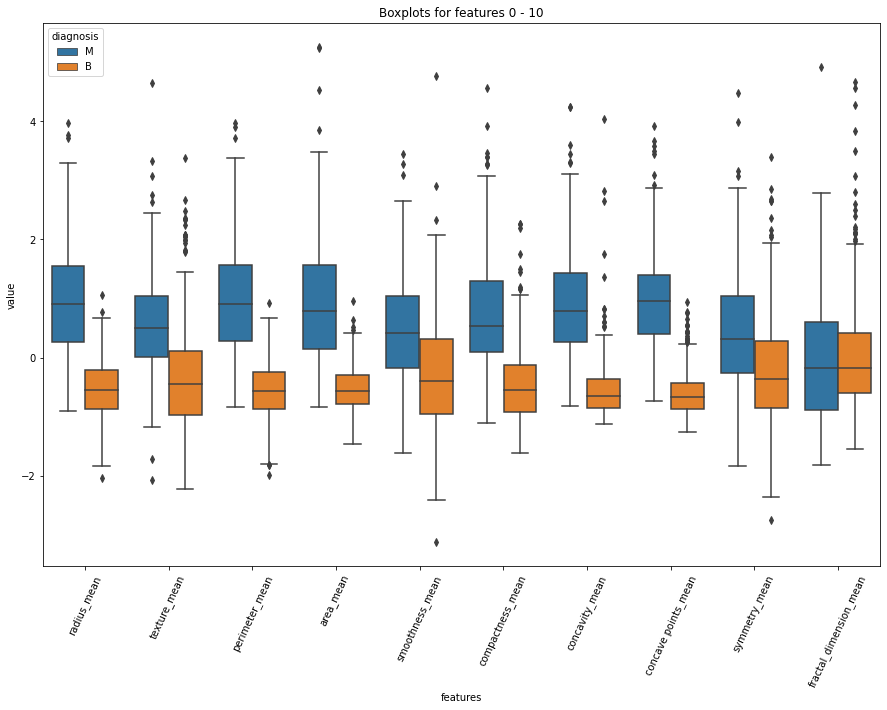

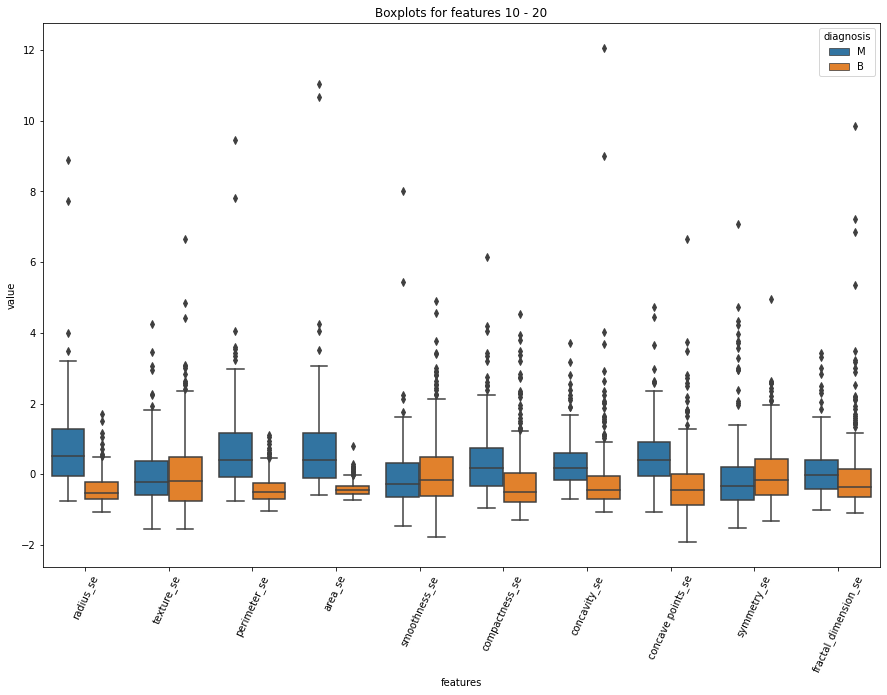

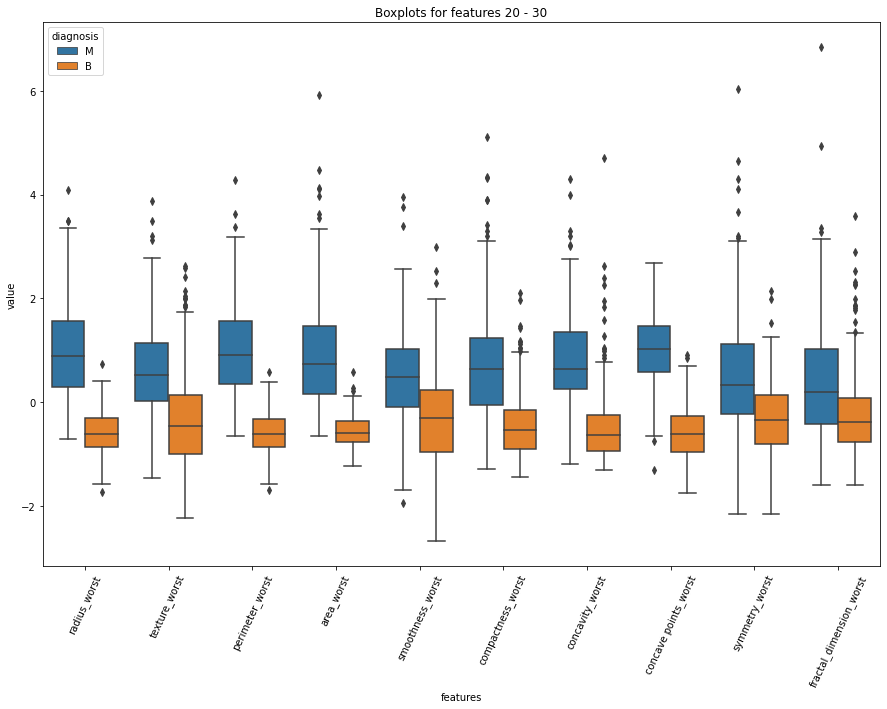

In [13]:
for start_feature in [0, 10, 20]:
    if start_feature == 20:
        data = pd.concat([y, data_std.iloc[:, start_feature:]], axis=1)
    else:
        data = pd.concat([y, data_std.iloc[:, start_feature:start_feature+10]], axis=1)
    data = pd.melt(data, id_vars='diagnosis', var_name='features',
                value_name='value')
    plt.figure(figsize=(15, 10))
    sns.boxplot(x='features', y='value', hue='diagnosis', data=data)
    plt.title(f'Boxplots for features {start_feature} - {start_feature + 10}')
    plt.xticks(rotation=65);

***

In contrast with violinplots, boxplots allow us to see outliers too. And of course, we can compare distributions:

- indeed, features mentioned before as candidates to drop, like 'fractal dimension mean', 'texture se', 'smoothness se', 'symmetry se' don't separate the target clasess properly, and we can see how boxes overlap for these features

- sometimes outliers for a feature in one class might have the same values as normal points in this feature but for other class: this means that such points will have bad effect on our classifier (like in 'points mean', 'raidius se', 'perimeter se', 'area se', 'area worst', 'concavity worst' ,etc)

### 6. Using Joint Plots for Feature Comparison
***

Some features might have linear dependency, to check this hypothesis we can plot a joint plot for 'suspicious' pair
***

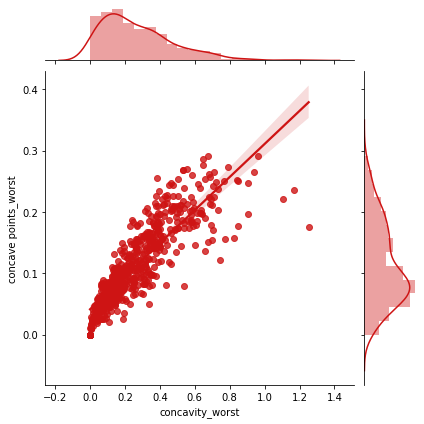

In [14]:
sns.jointplot(x.loc[:, 'concavity_worst'], x.loc[:, 'concave points_worst'], kind='regg',
             color='#ce1414')

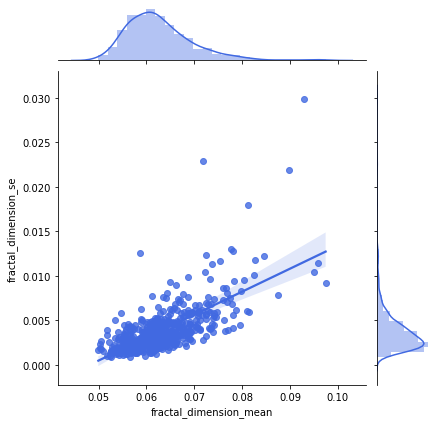

In [15]:
sns.jointplot(x.loc[:, 'fractal_dimension_mean'], x.loc[:, 'fractal_dimension_se'], kind='regg',
             color='royalblue')
# here it's obvious that we should get linear connection

In both cases we can see linear dependency

### 7. Observing the Distribution of Values and their Variance with Swarm Plots
***

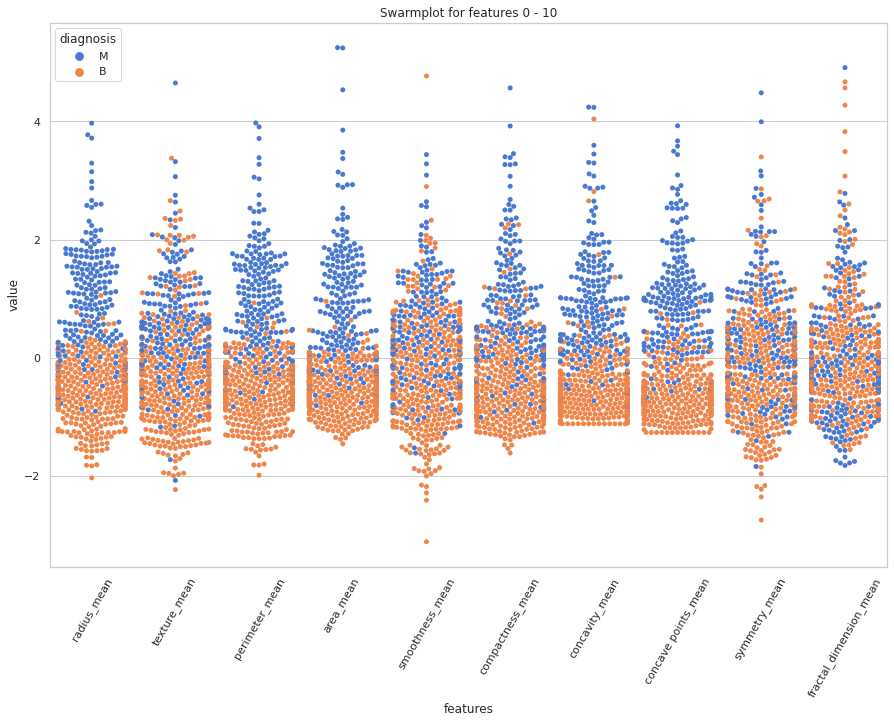

In [16]:
def swarm_plot(x, start_feature=0):
    sns.set(style='whitegrid', palette='muted')
    data = x
    data_std = (data - data.mean())/data.std()
    data = pd.concat([y, data_std.iloc[:, start_feature:start_feature+10]], axis=1)
    data = pd.melt(data, id_vars='diagnosis', var_name='features',
                value_name='value')
    plt.figure(figsize=(15, 10))
    sns.swarmplot(x = 'features', y='value', hue='diagnosis', data=data)
    plt.title(f'Swarmplot for features {start_feature} - {start_feature + 10}')
    plt.xticks(rotation=60);

swarm_plot(x, 0)

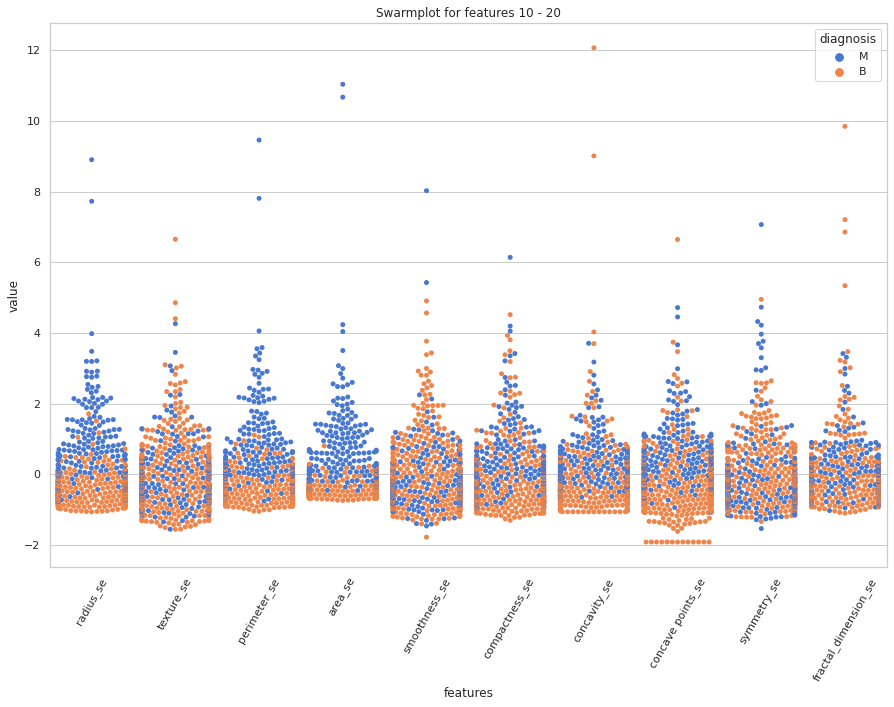

In [17]:
swarm_plot(x, 10)

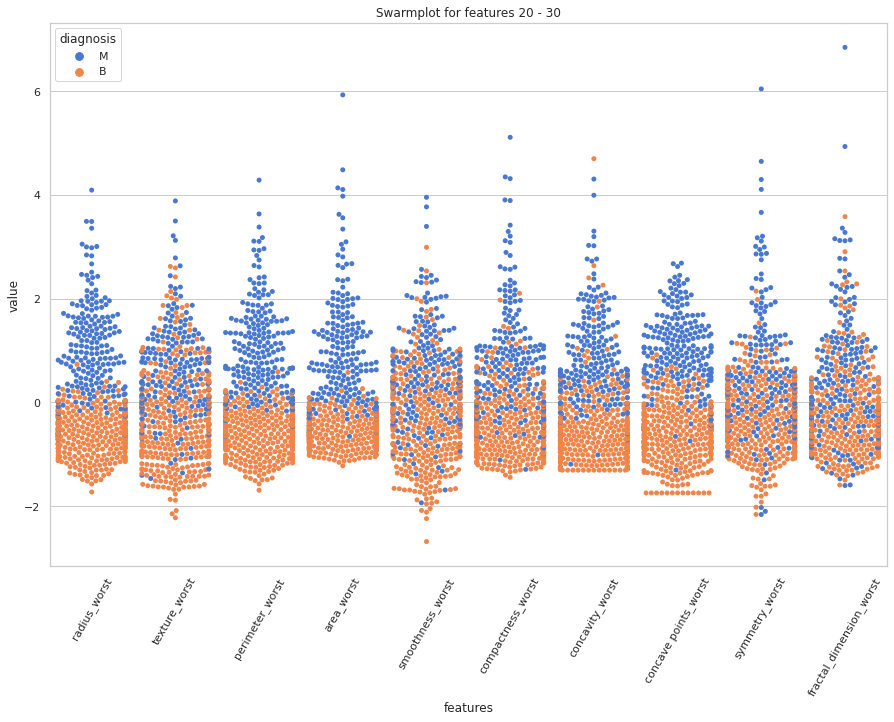

In [18]:
swarm_plot(x, 20)

***
Some features separate target classes really well, like 'concave points mean', 'concavity se', 'radius worst', 'perimeter worst', 'area worst', 'concavity worst'

But other are really messy, the points from different classes mix up together making prediction power of such features very low, especially for: 'fractal dimension mean', 'texture se', 'smoothness se', 'symmetry se', 'fractal dimension se', etc
***

### 8. Observing all Pair-wise Correlations
***
Time to see linear dependencies between the features
***

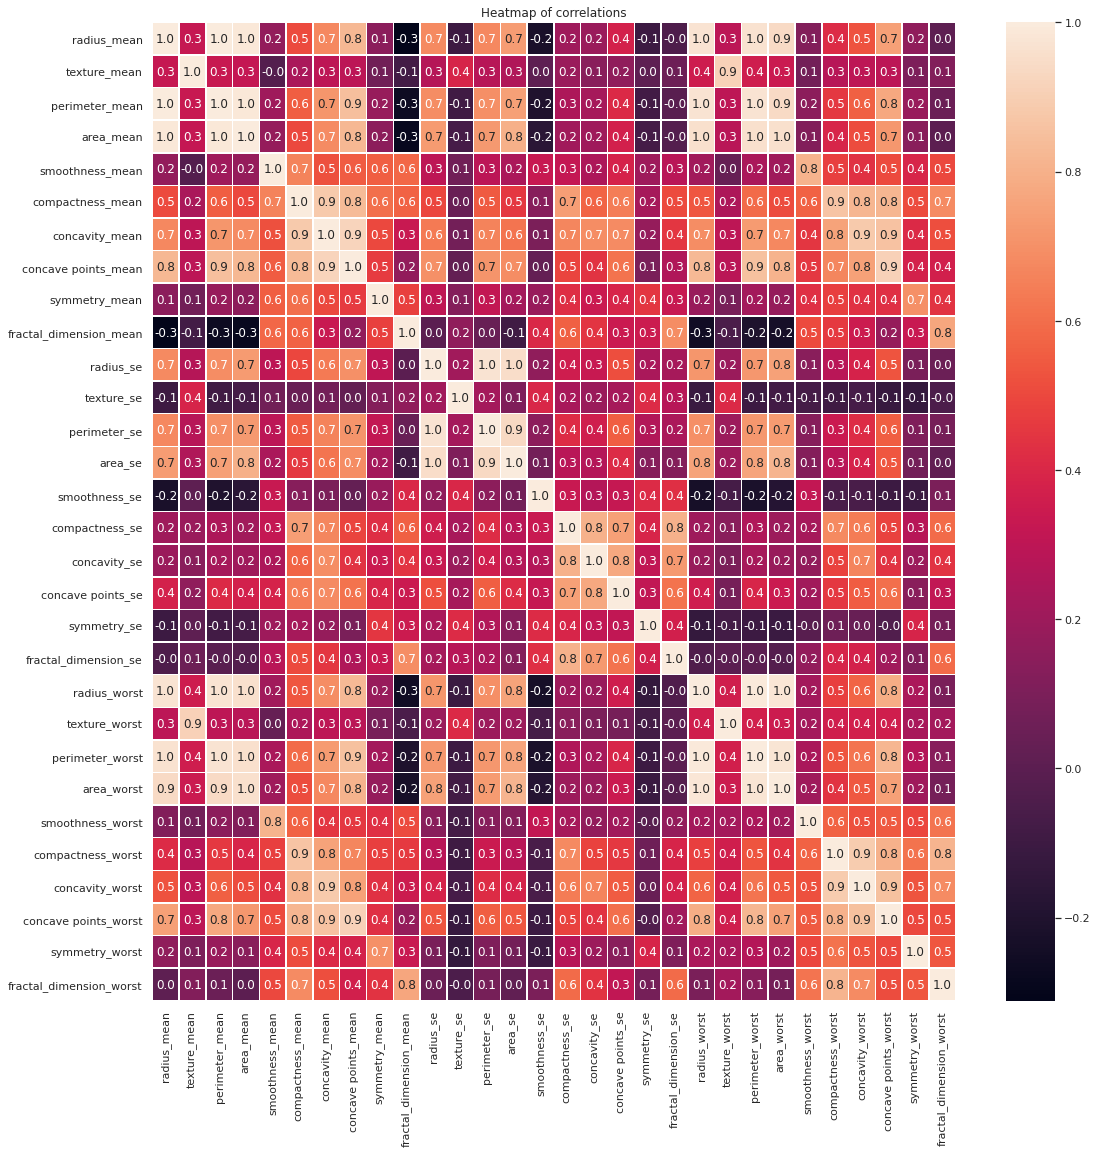

In [19]:
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(x.corr(), annot=True, linewidth=0.5, fmt='.1f', ax=ax)
plt.title('Heatmap of correlations');